In [171]:
import matplotlib.pyplot as plt
# import deeptrack as dt
import numpy as np
bottleneck_size=128

In step 1, you pretrain a convolutional encoder and decoder as an autoencoder. This involves passing frames individually through the encoder, obtaining a downsampled representation, and then reconstructing the original frame using the decoder. The bottleneck represents the compressed representation of the input frames, and its performance depends on the number of features extracted at this bottleneck layer. Generally, increasing the number of features can lead to better reconstruction quality but may also increase computational complexity.

In step 2, instead of using a convolutional encoder, you use a vision transformer as the image encoder network. A vision transformer is a type of neural network architecture that has gained popularity for image classification tasks. It consists of a series of transformer blocks, similar to those used in natural language processing tasks, but adapted for image processing.

In this step, you train a vision transformer to encode the input frames into a latent representation. The "class token output" refers to the output token that represents the entire image, akin to the [CLS] token used in NLP tasks with transformers. You then use the same decoder structure as in step 1 to reconstruct the original frames from this latent representation.

Additionally, you plot and interpret the output from the attention gates within the vision transformer. Attention gates are mechanisms used within transformer networks to weight the importance of different parts of the input when processing it. Visualizing the attention weights can provide insights into which parts of the input the network focuses on during encoding. This analysis can help understand how the vision transformer processes the input frames and generates the latent representation used for reconstruction.

float32


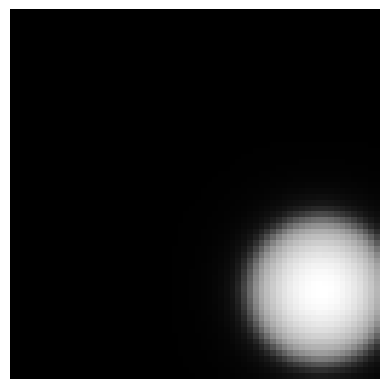

(2000, 25, 64, 64, 1)
(2000, 25, 64, 64, 1)
<class 'torch.Tensor'>
32
Element 0: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 1: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 2: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 3: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 4: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 5: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 6: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 7: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 8: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 9: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 10: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 11: Type=<class 'torch.Tensor'> Shape=torch.Size([25, 64, 64, 1])
Element 12: Type=<class 'torch.Tensor'> Shape=torch.

In [174]:
from torch.utils.data import DataLoader
import torch
# from torchvision import transforms

# Load the npz file
data = np.load("particle_sequences.npz")
images = data["sequences"]
print(images.dtype) 
plt.imshow(images[0][0].squeeze(), cmap='gray') 
plt.axis('off')
plt.show()
print(images.shape)
# images= images.reshape(-1,1,64,64)
print(images.shape)
# Define the CustomDataset class
# class CustomDataset():
#     def __init__(self, images):
#         self.images = images



#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         x = self.images[idx]
#         # Convert NumPy array to PyTorch tensor and then to float
#         x = torch.tensor(x).float()
       
#         return x, x  # Return the input and output tensors (both are the same)
# # normalize = transforms.Normalize(mean=[0.5], std=[0.5])

# # Create an instance of the custom dataset class
# custom_dataset = CustomDataset(images)

# Create a DataLoader
loader = DataLoader(images, batch_size=8, shuffle=True)  # Corrected line

from torch.utils.data import random_split

train_size = int(0.8 * len(images))
test_size = len(images) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(images, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  
# for data in train_loader:
#     print(data.shape)

first_batch = next(iter(train_loader))

print(type(first_batch))
print(len(first_batch))


for idx, item in enumerate(first_batch):
    print(f"Element {idx}: Type={type(item)} Shape={getattr(item, 'shape', 'N/A')}")

In [175]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# import torch.nn.functional as F

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()        
#         # N, 1, 64, 64
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 32, 32
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 16, 16
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> N, 64, 8, 8
#             nn.ReLU(),
#             nn.Conv2d(64, 128, 3, stride=2, padding=1), # -> N, 128, 4, 4
#             nn.ReLU(),
#             nn.Flatten(), # -> N, 128*4*4
#             nn.Linear(128*4*4, 16) # -> N, 4 (Bottleneck layer)
#         )
        
#         # N , 4
#         self.decoder = nn.Sequential(
#             nn.Linear(16, 128*4*4), # -> N, 128*4*4
#             nn.LeakyReLU(0.1),
#             nn.Unflatten(1, (128, 4, 4)), # -> N, 128, 4, 4
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # N, 64, 8, 8
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 32, 16, 16
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 32, 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 64, 64
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


In [ ]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()        
#                 # N, 1, 28, 28
#         self.encoder = nn.Sequential(
#                     nn.Conv2d(1, 16, 3, stride=2, padding=1),   # -> N, 16, 32, 32
#                     nn.ReLU(),
#                     nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> N, 32, 16, 16
#                     nn.ReLU(),
#                     nn.Conv2d(32, 64, 3, stride=2, padding=1),  # -> N, 64, 8, 8
#                     nn.ReLU(),
#                     nn.Conv2d(64, 128, 3, stride=2, padding=1), # -> N, 128, 4, 4
#                     nn.ReLU(),
#                     nn.Conv2d(128, 256, 3, stride=2, padding=1), # -> N, 256, 2, 2
#                     nn.ReLU(),
#                     nn.Conv2d(256, 512, 3, stride=2, padding=1), # -> N, 512, 1, 1
#                     nn.ReLU(),
#                     nn.Conv2d(512, 1024, 1), # -> N, 1024, 1, 1
#                     nn.ReLU(),
#                     nn.Conv2d(1024, 2048, 1), # -> N, 2048, 1, 1
#                     # nn.ReLU(),
#                     # nn.Conv2d(2048, 4096, 1) # -> N, 4096, 1, 1
#                 )
                
#         self.decoder = nn.Sequential(
#             # nn.ConvTranspose2d(4096, 2048, 1), # -> N, 2048, 1, 1
#             # nn.ReLU(),
#             nn.ConvTranspose2d(2048, 1024, 1), # -> N, 1024, 1, 1
#             nn.ReLU(),
#             nn.ConvTranspose2d(1024, 512, 1), # -> N, 512, 1, 1
#             nn.ReLU(),
#             nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # -> N, 256, 2, 2
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # -> N, 128, 4, 4
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # -> N, 64, 8, 8
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # -> N, 32, 16, 16
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # -> N, 16, 32, 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> N, 1, 64, 64
#             nn.Sigmoid()
#         )





#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [ ]:
# import torch.nn.functional as F

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()        
#         # N, 1, 64, 64
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 32, 32
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 16, 16
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> N, 64, 8, 8
#             nn.ReLU(),
#             nn.Conv2d(64, 128, 3, stride=2, padding=1), # -> N, 128, 4, 4
#             nn.ReLU(),
#             nn.Flatten(), # -> N, 128*4*4
#             nn.Linear(128*4*4, 4) # -> N, 4 (Bottleneck layer)
#         )
        
#         # N , 4
#         self.decoder = nn.Sequential(
#             nn.Linear(4, 128*4*4), # -> N, 128*4*4
#             nn.ReLU(),
#             nn.Unflatten(1, (128, 4, 4)), # -> N, 128, 4, 4
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # N, 64, 8, 8
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 32, 16, 16
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 32, 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 64, 64
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn

class SequenceAutoencoder(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        # Increased depth in the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # N, 16, 32, 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # N, 32, 16, 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # N, 64, 8, 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # N, 128, 4, 4
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # N, 256, 2, 2
            nn.ReLU(),
            nn.Flatten(),  # Flatten to vector
            nn.Linear(256*2*2, bottleneck)  # Bottleneck layer
        )
        
        # Corresponding increase in the decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 256*2*2),  # Match to flattened output of last encoder layer
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (256, 2, 2)),  # Unflatten to the output shape of the last encoder conv layer
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # N, 128, 4, 4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # N, 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # N, 32, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 32, 32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 64, 64
            nn.Sigmoid()
        )



    def forward(self, x):
        # print(x.shape)
        # x= torch.squeeze(x, -1)
        batch_size, seq_length, height, width = x.shape
        x = x.view(batch_size * seq_length, 1, height, width)

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        decoded = decoded.view(batch_size, seq_length, height, width)
        return decoded


In [183]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = SequenceAutoencoder(bottleneck=bottleneck_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Using device: cuda


In [189]:
num_epochs = 40
outputs = []

for epoch in range(num_epochs):
    for (img) in train_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img = img.float()
        img=torch.squeeze(img, -1)
        img = img.to(device)
        # print(img.shape)
        recon = model(img)
        # print(recon.shape)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    
    outputs.append((epoch, img.cpu(), recon.cpu()))

Epoch:1, Loss:19.2655
Epoch:2, Loss:13.2503
Epoch:3, Loss:20.2275
Epoch:4, Loss:25.2489
Epoch:5, Loss:22.0438
Epoch:6, Loss:23.0756
Epoch:7, Loss:20.9607
Epoch:8, Loss:20.7954
Epoch:9, Loss:25.2999
Epoch:10, Loss:22.4850
Epoch:11, Loss:19.9914
Epoch:12, Loss:21.2856
Epoch:13, Loss:12.8423
Epoch:14, Loss:17.5598
Epoch:15, Loss:15.3589
Epoch:16, Loss:19.7510
Epoch:17, Loss:17.1194
Epoch:18, Loss:18.4357
Epoch:19, Loss:15.9869
Epoch:20, Loss:20.6111
Epoch:21, Loss:25.6331
Epoch:22, Loss:15.9578
Epoch:23, Loss:12.4997
Epoch:24, Loss:20.2643
Epoch:25, Loss:17.6676
Epoch:26, Loss:14.8971
Epoch:27, Loss:13.5577
Epoch:28, Loss:20.7976
Epoch:29, Loss:20.7424
Epoch:30, Loss:10.4444
Epoch:31, Loss:19.2666
Epoch:32, Loss:24.1839
Epoch:33, Loss:17.5702
Epoch:34, Loss:18.7710
Epoch:35, Loss:21.1880
Epoch:36, Loss:24.3381
Epoch:37, Loss:14.2280
Epoch:38, Loss:16.3561
Epoch:39, Loss:16.7169
Epoch:40, Loss:17.9392


In [191]:
test_outputs = []

model.eval()

total_test_loss = 0

with torch.no_grad(): 
    for img in test_loader:
        img = img.float()
        img=torch.squeeze(img, -1)
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        total_test_loss += loss.item()

        test_outputs.append((img.cpu(), recon.cpu()))

average_test_loss = total_test_loss / len(test_loader)

print(f'Average Test Loss: {average_test_loss:.4f}')


Average Test Loss: 18.4705


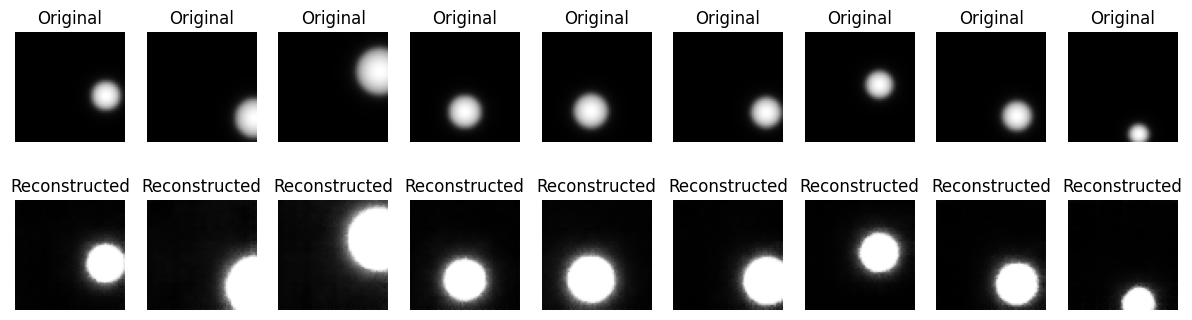

In [192]:
import matplotlib.pyplot as plt

def plot_test_images(test_outputs, num_images=9):
    plt.figure(figsize=(15, 4))
    plt.gray()

    for i, (imgs, recons) in enumerate(test_outputs):
        if i >= num_images:
            break

        imgs = imgs[:1]  
        recons = recons[:1]

        imgs = imgs.detach().numpy()
        recons = recons.detach().numpy()

        # Plotting original images
        plt.subplot(2, num_images, i + 1)
        img = imgs[0,0].squeeze()  #
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, num_images, num_images + i + 1)
        recon = recons[0,0].squeeze()
        plt.imshow(recon)
        plt.axis('off')
        plt.title('Reconstructed')

    plt.show()

plot_test_images(test_outputs)


C:\Users\purus\AppData\Local\Temp\ipykernel_25216\2222390513.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 2))


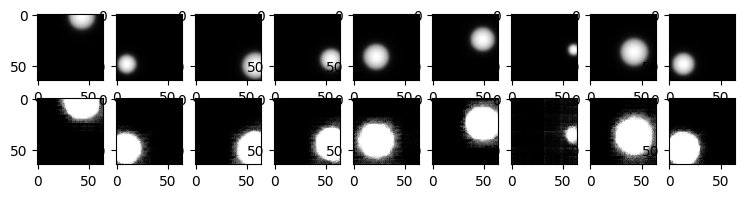

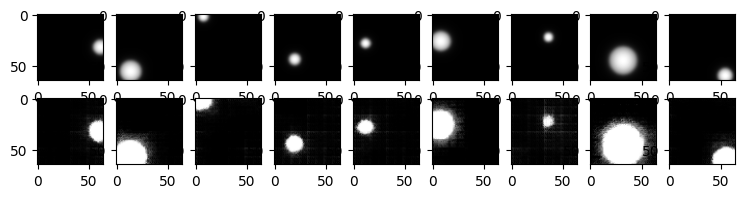

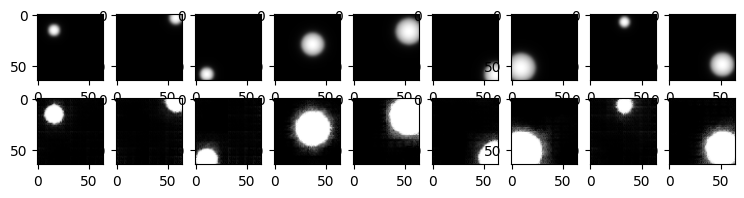

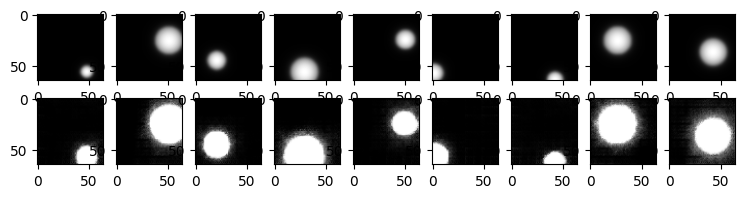

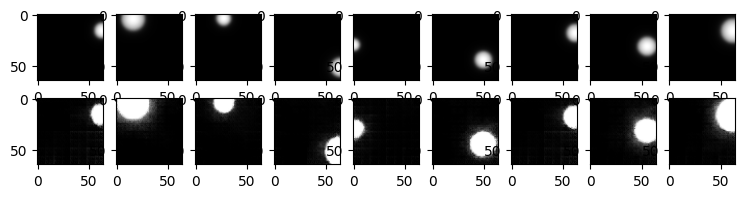

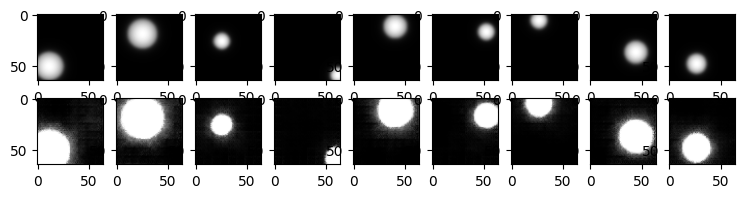

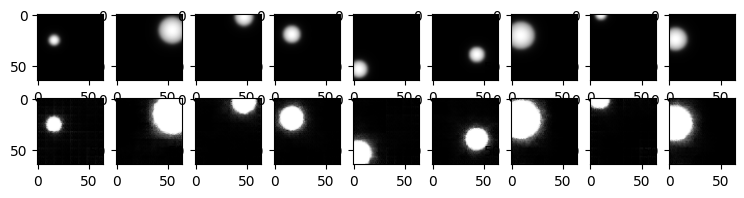

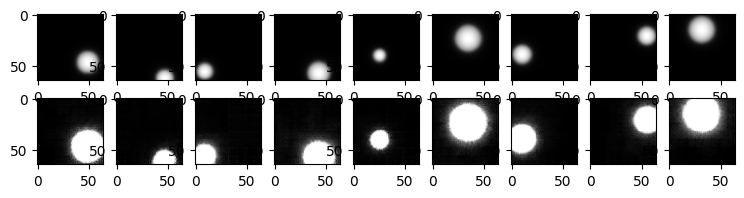

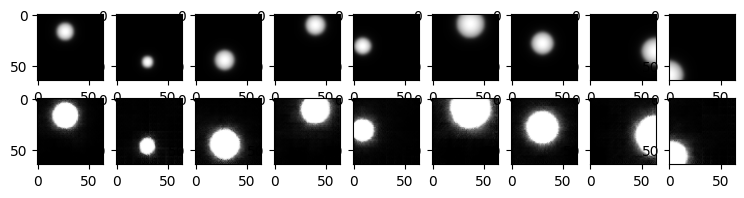

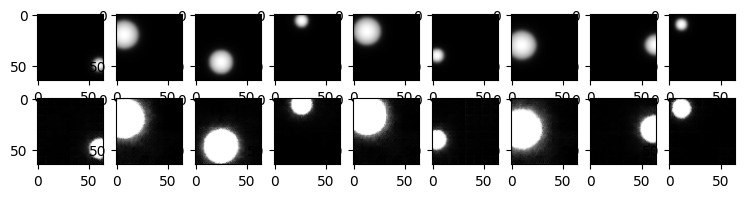

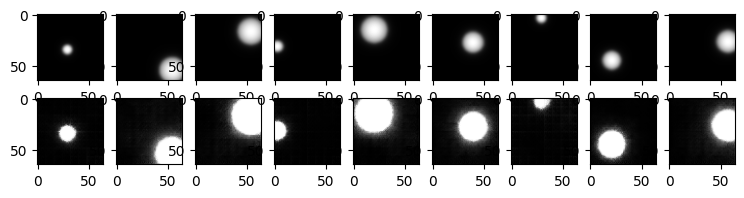

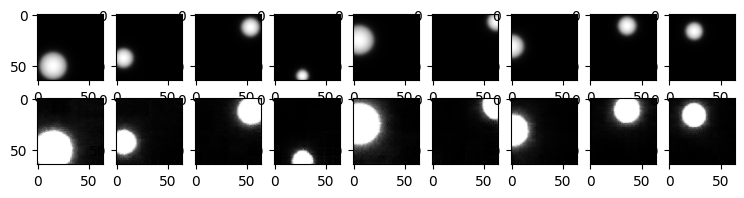

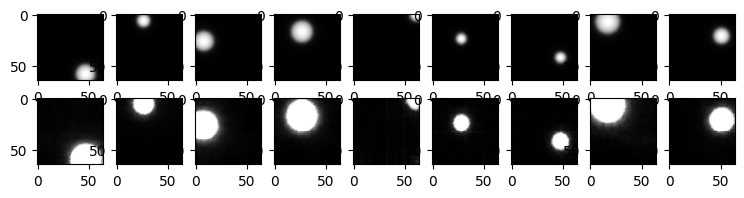

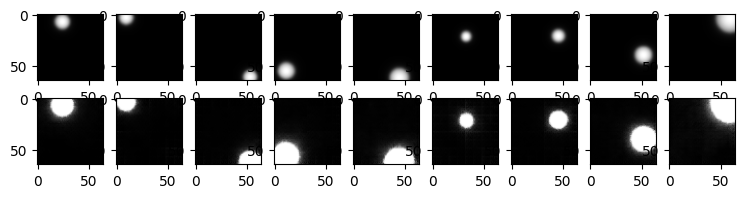

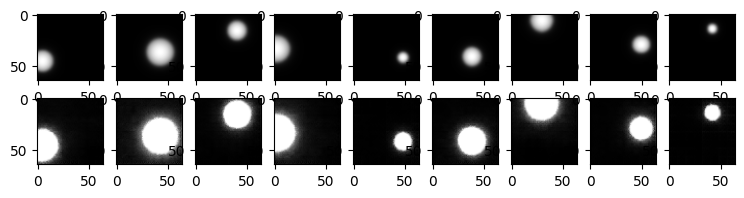

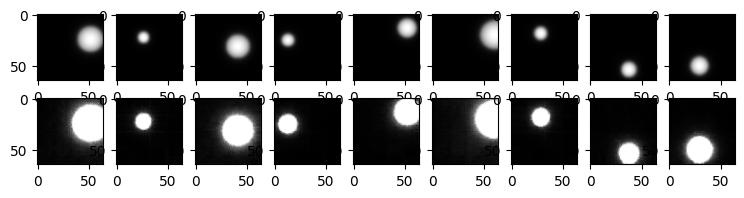

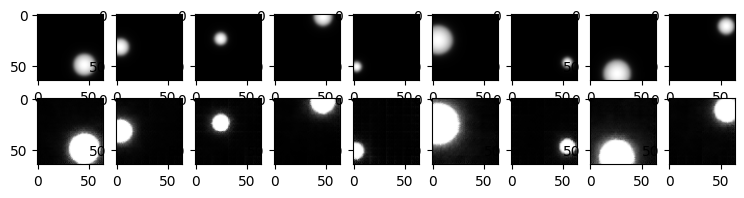

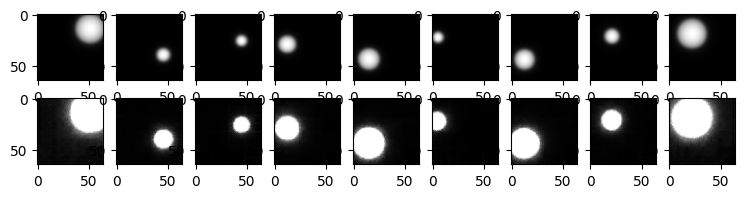

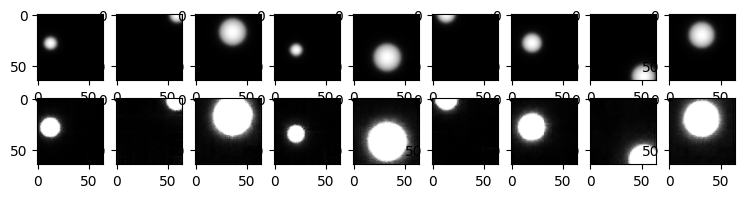

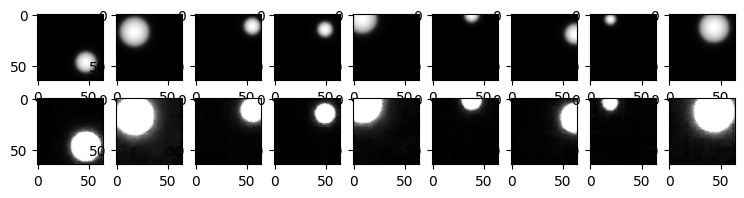

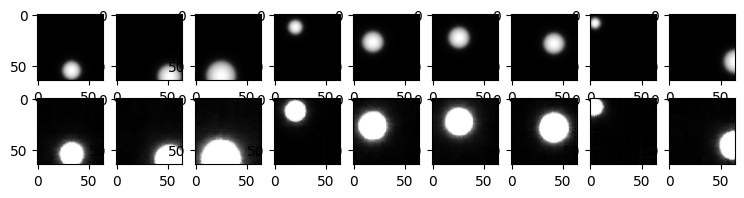

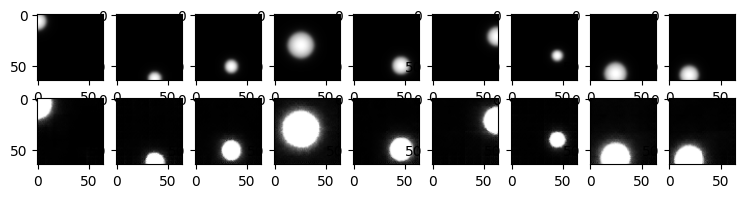

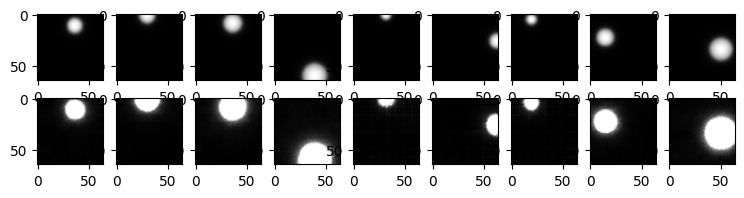

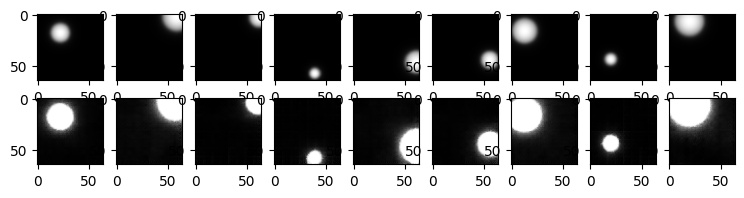

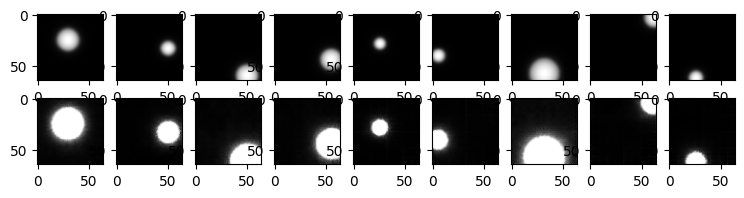

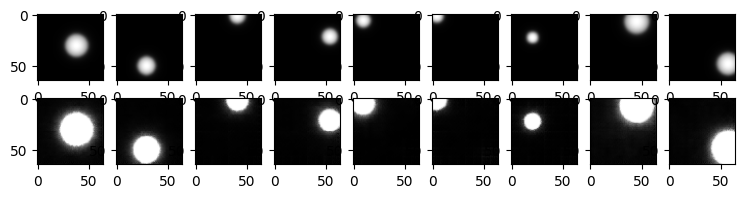

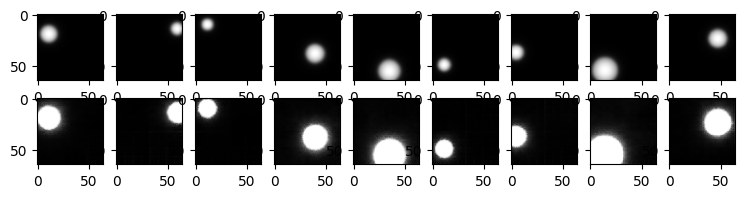

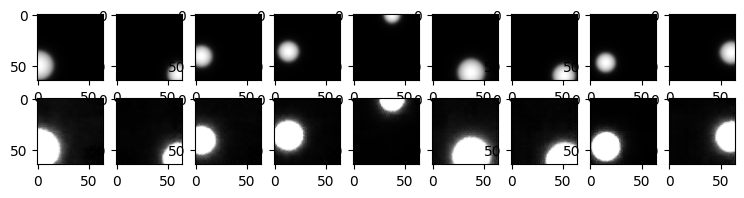

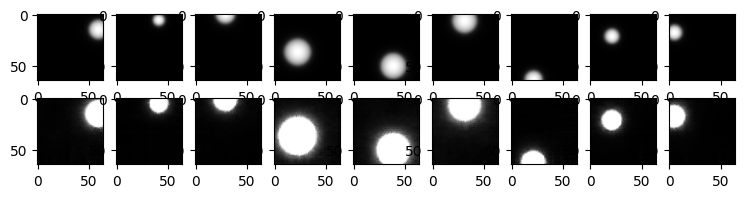

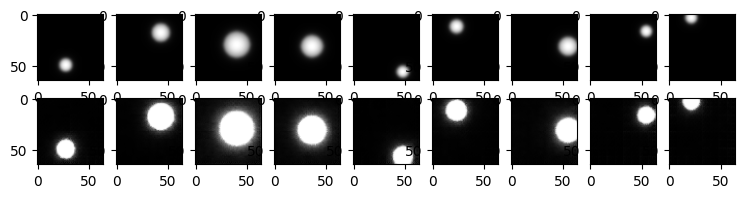

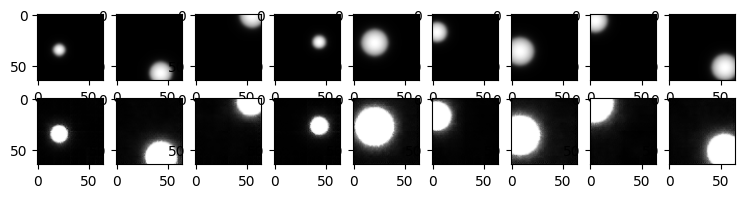

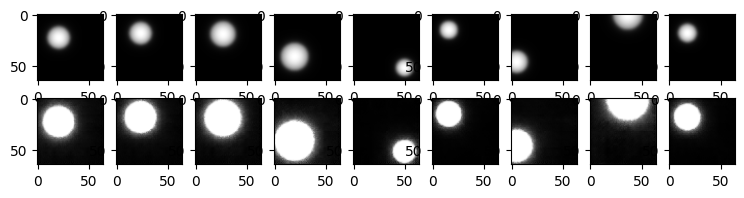

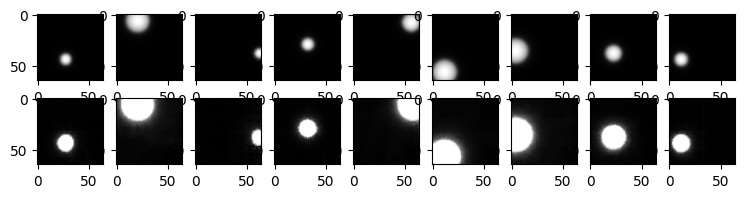

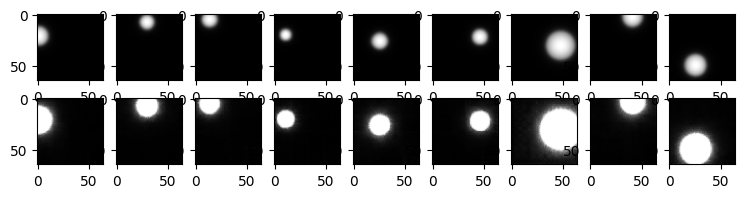

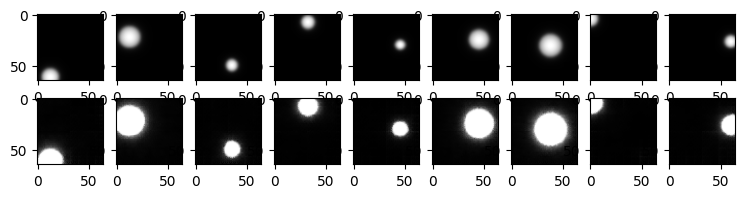

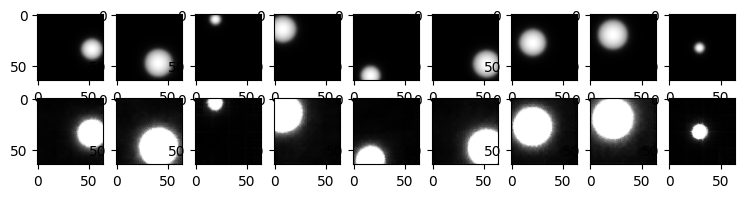

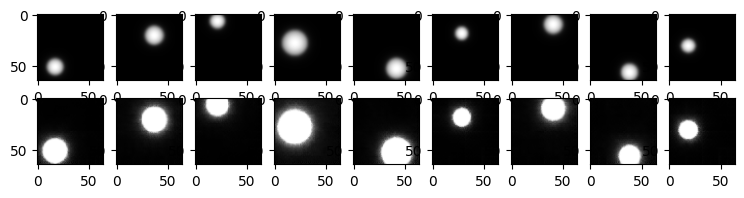

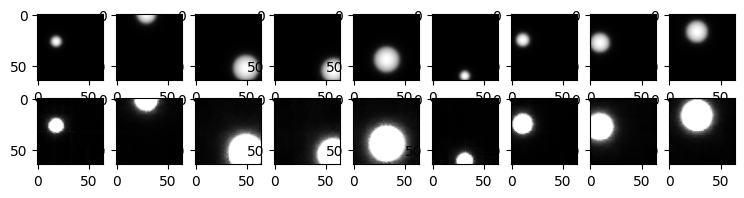

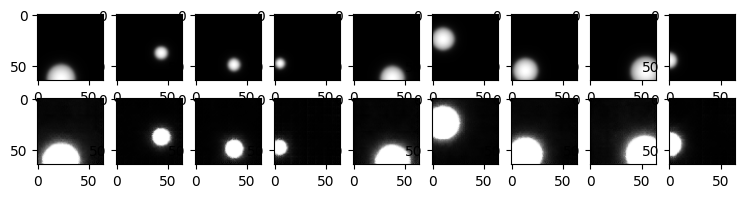

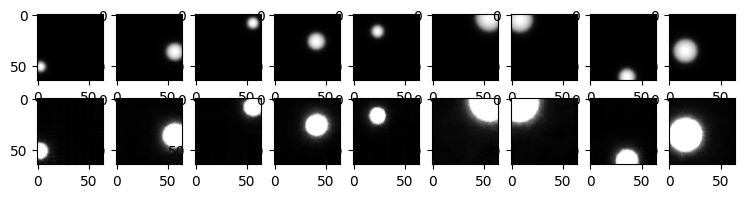

In [193]:
for k in range(0, num_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    # print(k)
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [194]:
model.eval()

encoder_state_dict = model.encoder.state_dict()
decoder_state_dict = model.decoder.state_dict()

encoder_path = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder/encoder_params.pth'
decoder_path = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder/decoder_params.pth'

torch.save(encoder_state_dict, encoder_path)
torch.save(decoder_state_dict, decoder_path)

In [195]:
import torch
import torch.nn as nn

class BottleneckExtractor(nn.Module):
    def __init__(self, bottleneck_size):
        super(BottleneckExtractor, self).__init__()
        self.bottleneck_size= bottleneck_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # N, 16, 32, 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # N, 32, 16, 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # N, 64, 8, 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # N, 128, 4, 4
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # N, 256, 2, 2
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(256*2*2, self.bottleneck_size)  
        )
    
    def forward(self, x):
        batch_size, seq_length, height, width = x.shape
        x=x.float()
        x = x.view(batch_size * seq_length, 1, height, width)
        
        bottleneck_features = self.encoder(x)
        bottleneck_features = bottleneck_features.view(batch_size,seq_length,self.bottleneck_size)
        return bottleneck_features
bottleneck_encoder = BottleneckExtractor(bottleneck_size=bottleneck_size)

encoder_weights = torch.load(r"C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\encoder_params.pth")
bottleneck_encoder.encoder.load_state_dict(encoder_weights)
for param in bottleneck_encoder.parameters():
    param.requires_grad = False

In [197]:
import torch
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bottleneck_encoder.to(device)
def save_encoded_features(model, data_loader, output_dir, use_bottleneck=True):

    os.makedirs(output_dir, exist_ok=True)

    model.eval()

    with torch.no_grad():
        for batch_idx, (inputs) in enumerate(data_loader):
            inputs=torch.squeeze(inputs, -1) 
            inputs = inputs.to(device) 
            
            btl_neck = model(inputs)
            # print(bottleneck.shape)
            features = btl_neck.cpu().numpy()

            # Check if using the bottleneck or CLS token (assuming CLS token is part of the bottleneck output)
            # if use_bottleneck:
            #     features = bottleneck.cpu().numpy()
            # else:
            #     # Assuming the CLS token is the first element in the last dimension of the bottleneck
            #     features = bottleneck[:, :, 0].cpu().numpy()  # Modify depending on actual structure

            # Save features to disk
            print(features.shape)
            feature_path = os.path.join(output_dir, f'features_batch_{batch_idx}.npy')
            np.save(feature_path, features)
            
            print(f"Saved encoded features for batch {batch_idx} at '{feature_path}'")




output_dir = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder'

save_encoded_features(bottleneck_encoder, train_loader, output_dir)


(32, 25, 128)
Saved encoded features for batch 0 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\features_batch_0.npy'
(32, 25, 128)
Saved encoded features for batch 1 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\features_batch_1.npy'
(32, 25, 128)
Saved encoded features for batch 2 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\features_batch_2.npy'
(32, 25, 128)
Saved encoded features for batch 3 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\features_batch_3.npy'
(32, 25, 128)
Saved encoded features for batch 4 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\features_batch_4.npy'
(32, 25, 128)
Saved encoded features for batch 5 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\features_batch_5.npy'
(32, 25, 128)
Saved encoded features for batch 6 at 'C:\Users\purus\Documents\Chal

In [198]:
import numpy as np
import os

def load_features(directory):
    files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')])
    all_features = [np.load(file) for file in files]
    return np.concatenate(all_features, axis=0)

features_directory = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder'
encoded_features = load_features(features_directory)  
print(encoded_features.shape)

(1600, 25, 128)


In [199]:
def create_sequences(features, sequence_length):
    inputs, targets = [], []
    for n in range(features.shape[0]):
        for i in range(features.shape[1] - sequence_length):
            input_seq = features[n, i:i + sequence_length, :]
            target_seq = features[n, i + 1:i + 1 + sequence_length, :]
            inputs.append(input_seq)
            targets.append(target_seq)
    
    return np.array(inputs), np.array(targets)

sequence_length = 24  
inputs, targets = create_sequences(encoded_features, sequence_length)
print(inputs.shape , targets.shape)

(1600, 24, 128) (1600, 24, 128)


In [200]:
from torch.utils.data import DataLoader, TensorDataset
def plot_sequence_and_prediction(input_sequence, predicted_frame, title="Sequence and Predicted Frame"):
    num_frames = input_sequence.shape[0] 
    fig, axes = plt.subplots(2, num_frames+len(predicted_frame), figsize=(2 * num_frames, 4))  # Adjust size as needed

    for i in range(num_frames):
        axes[0, i].imshow(input_sequence[i].squeeze(), cmap='gray', interpolation='none')
        axes[0, i].set_title(f'Frame {i+1}')
        axes[0, i].axis('off')

    for j in range (len(predicted_frame)):
        axes[1, num_frames+j].imshow(predicted_frame[j].squeeze(), cmap='gray', interpolation='none')
        axes[1, num_frames+j].set_title('Predicted')
        axes[1, num_frames+j].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
class TransformerPredictor(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers,num_heads, dropout=0.1):
        super(TransformerPredictor, self).__init__()
        self.transformer = nn.Transformer(
            d_model=feature_size,
            nhead=num_heads,
            num_encoder_layers=4,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.output_layer = nn.Linear(feature_size, feature_size)

    def forward(self, src, tgt):
        #  src and tgt are (batch, seq, feature)
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1))
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        return self.output_layer(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask


class Decoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 256*2*2),
            nn.ReLU(),
            nn.Unflatten(1, (256, 2, 2)),  

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # Output: N, 128, 4, 4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # Output: N, 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Output: N, 32, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: N, 16, 32, 32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Output: N, 1, 64, 64
            nn.Sigmoid() 
        )
    



    def forward(self, x):
        x = x.view(-1, x.size(-1))  
        x = self.decoder(x) 
        return x.view(x.size(0), 1, 64, 64)
    
decoder = Decoder(bottleneck_size=bottleneck_size).to(device)
decoder_weights = torch.load(r"C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\decoder_params.pth")
decoder.decoder.load_state_dict(decoder_weights)

for parm in decoder.parameters():
    parm.requires_grad = False
train_data = TensorDataset(torch.from_numpy(inputs).float(), torch.from_numpy(targets).float())
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
model = TransformerPredictor(feature_size=bottleneck_size, hidden_dim=256, num_layers=16, num_heads=2).to(device)


Epoch 1, Loss: 6052.7666015625


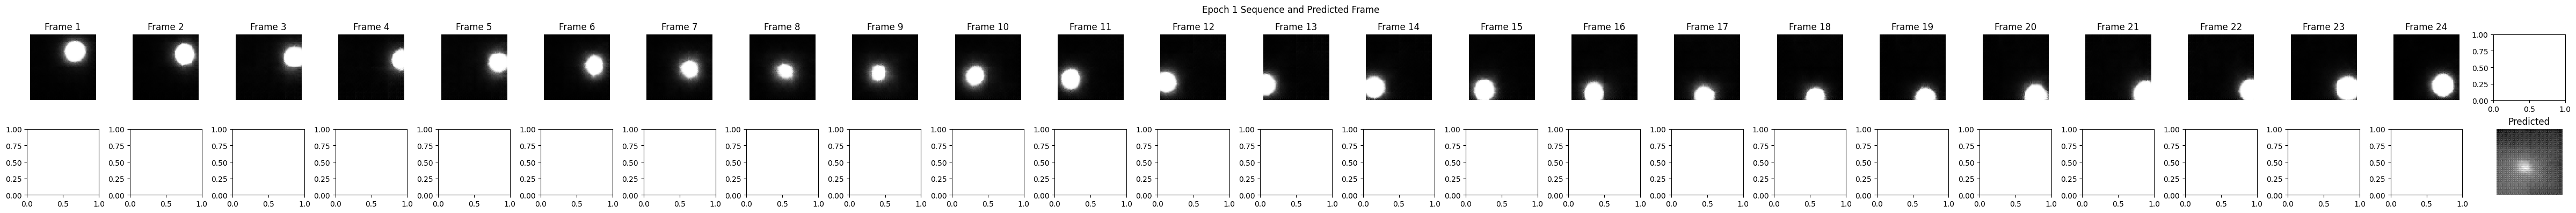

Epoch 2, Loss: 9706.08203125


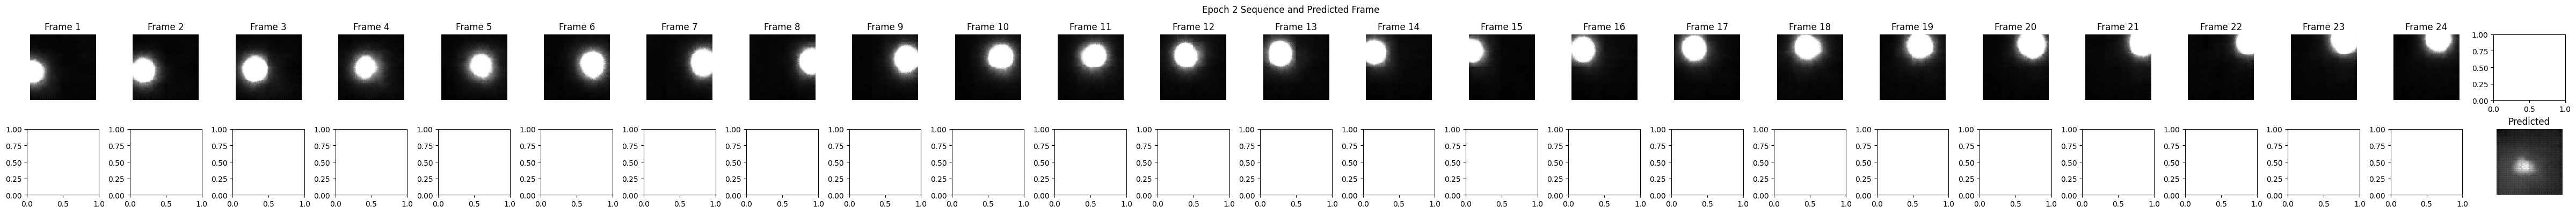

Epoch 3, Loss: 11109.3291015625
Epoch 4, Loss: 5917.6005859375


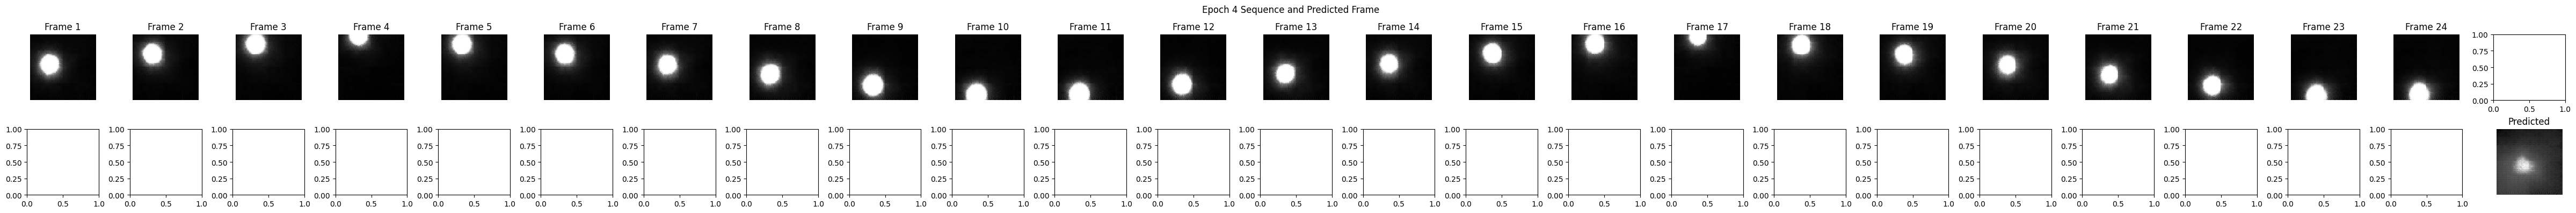

Epoch 5, Loss: 10145.9697265625
Epoch 6, Loss: 9377.9306640625


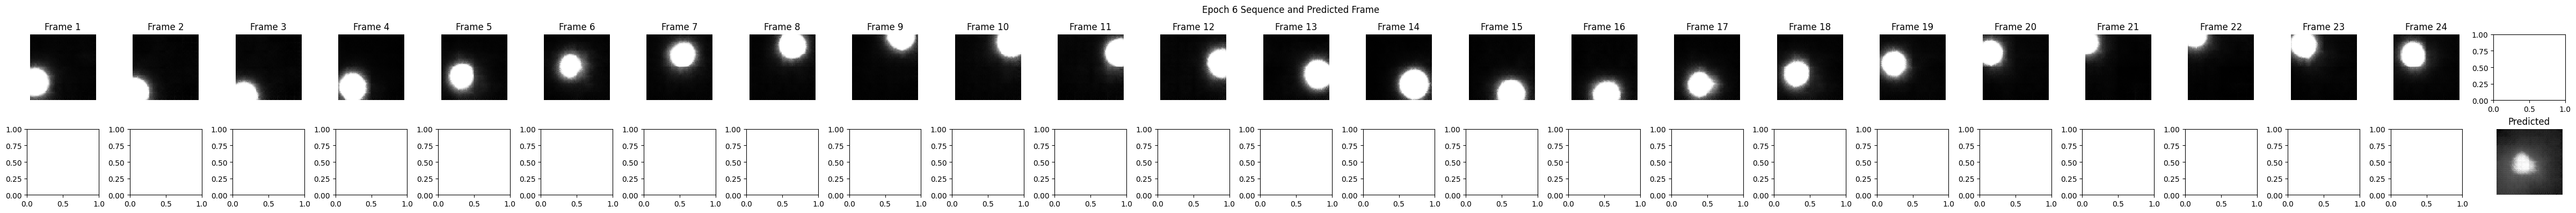

Epoch 7, Loss: 11645.6181640625
Epoch 8, Loss: 12505.916015625


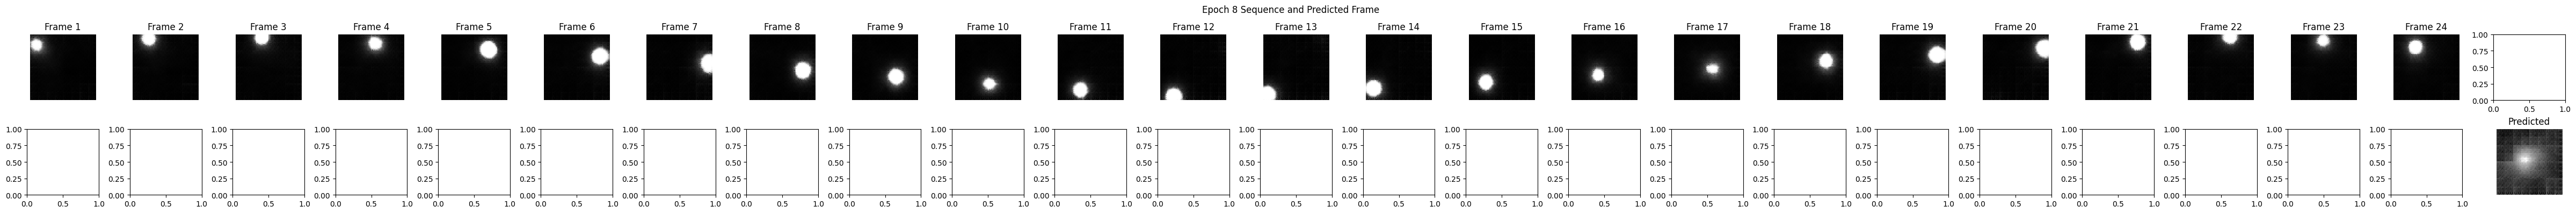

Epoch 9, Loss: 11653.5859375
Epoch 10, Loss: 7988.75537109375


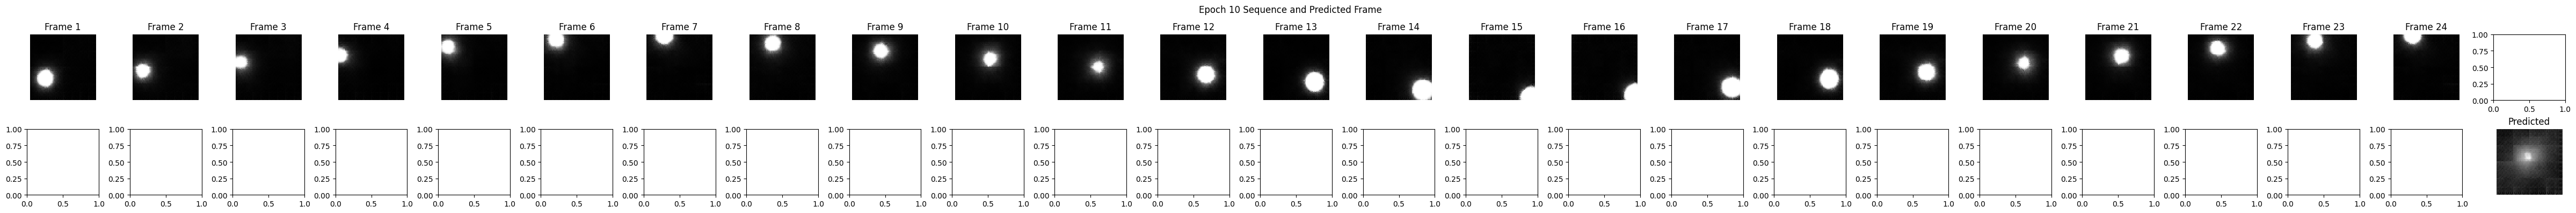

Epoch 11, Loss: 6380.80224609375
Epoch 12, Loss: 9039.490234375


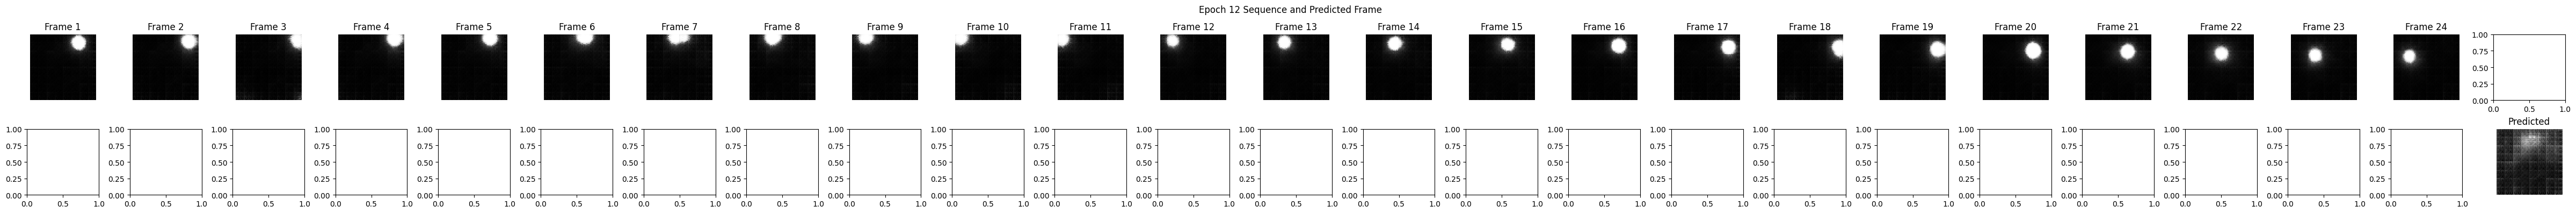

Epoch 13, Loss: 8910.380859375
Epoch 14, Loss: 9172.8798828125


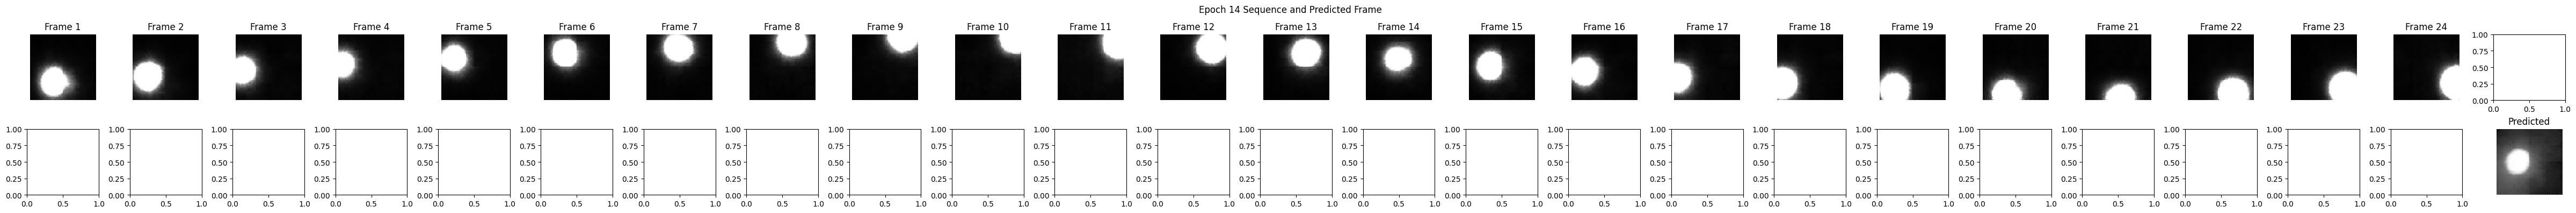

Epoch 15, Loss: 5210.658203125
Epoch 16, Loss: 6218.45849609375


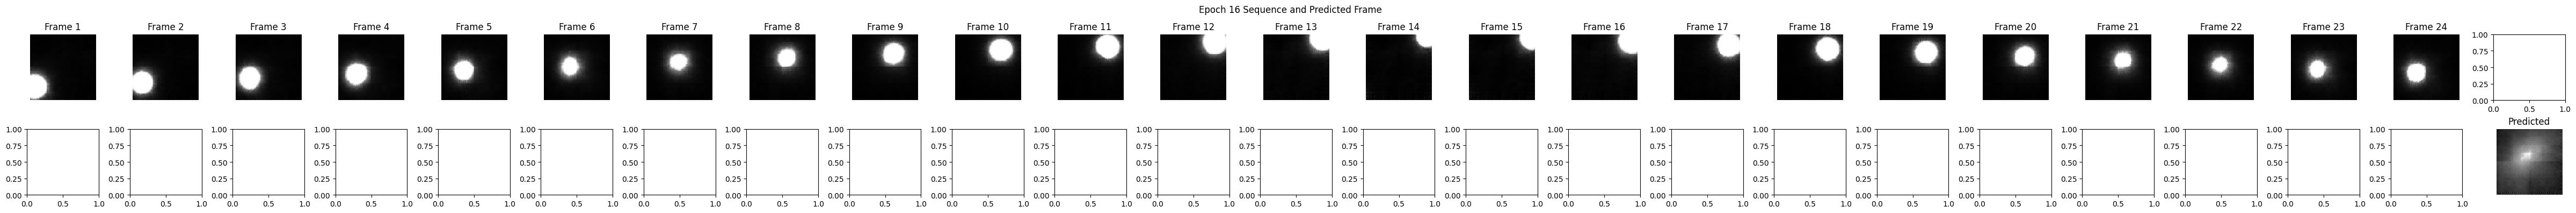

Epoch 17, Loss: 5652.69287109375
Epoch 18, Loss: 6185.30029296875


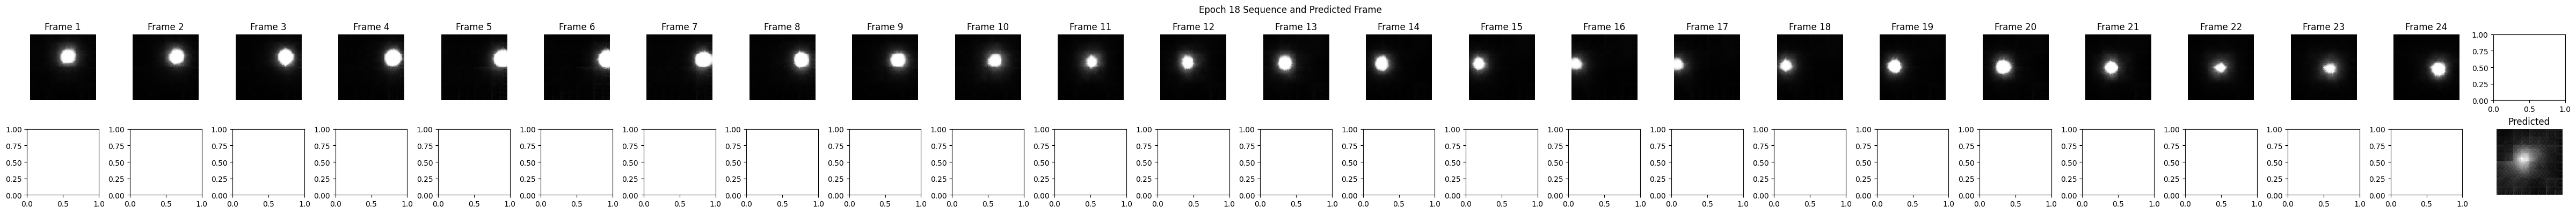

Epoch 19, Loss: 5373.59423828125
Epoch 20, Loss: 4384.10546875


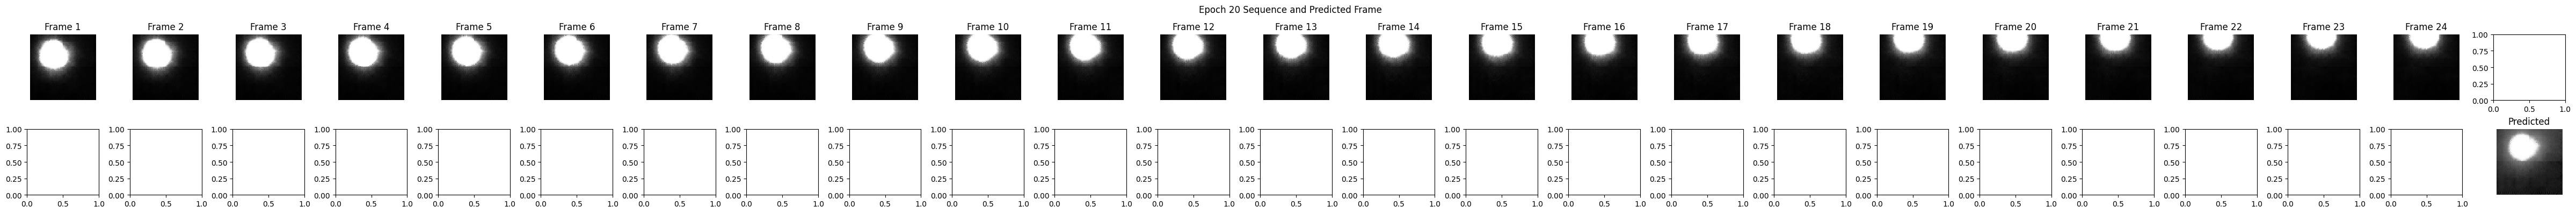

Epoch 21, Loss: 9624.8544921875
Epoch 22, Loss: 5851.580078125


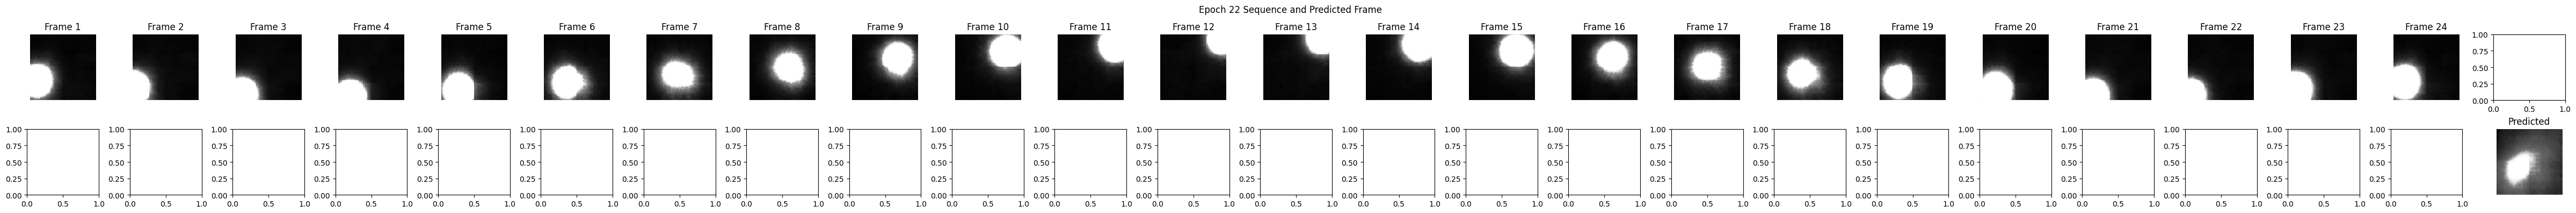

Epoch 23, Loss: 7505.9130859375
Epoch 24, Loss: 8286.6064453125


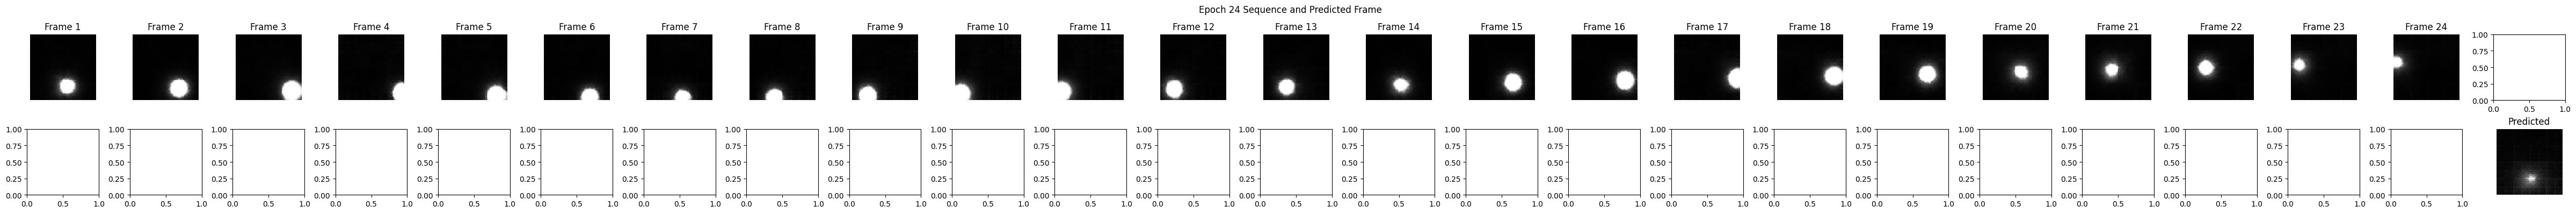

Epoch 25, Loss: 7563.5234375
Epoch 26, Loss: 6390.6123046875


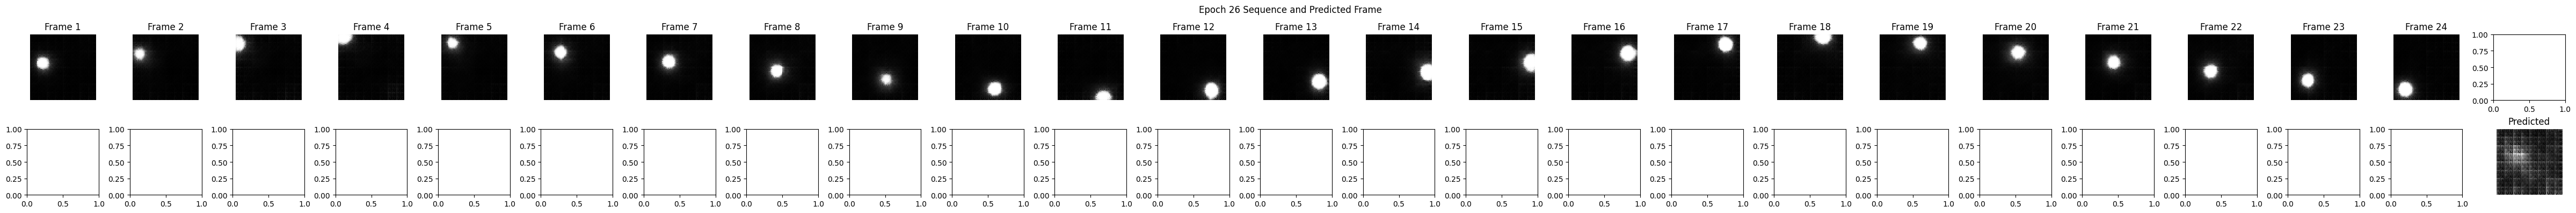

Epoch 27, Loss: 8120.357421875
Epoch 28, Loss: 9434.947265625


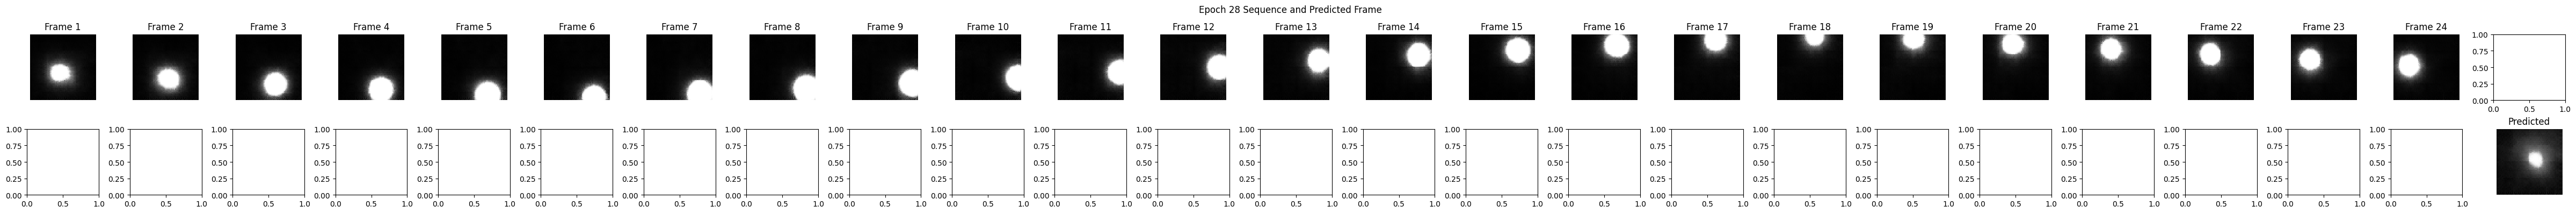

Epoch 29, Loss: 6699.9150390625
Epoch 30, Loss: 6458.65625


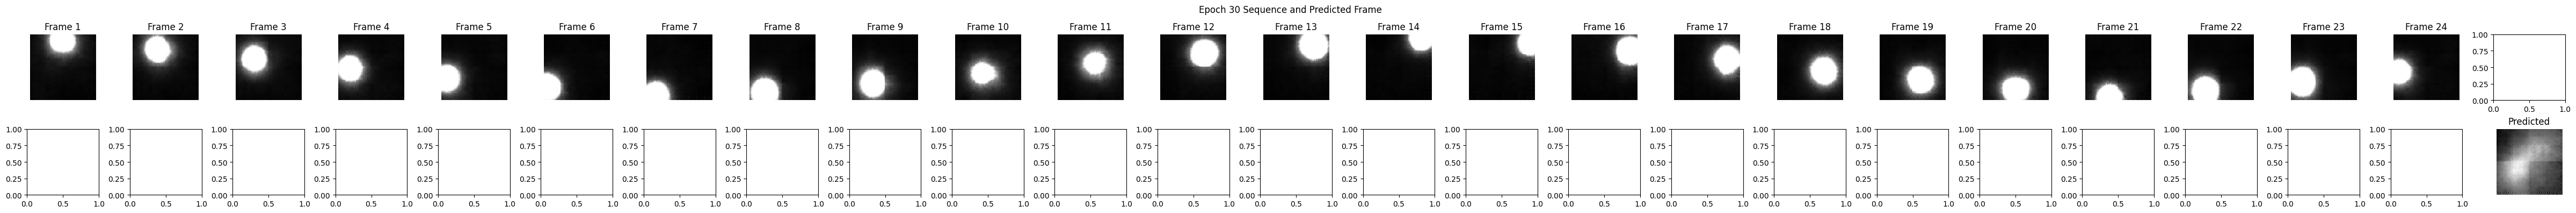

Epoch 31, Loss: 7324.85888671875
Epoch 32, Loss: 5962.96484375


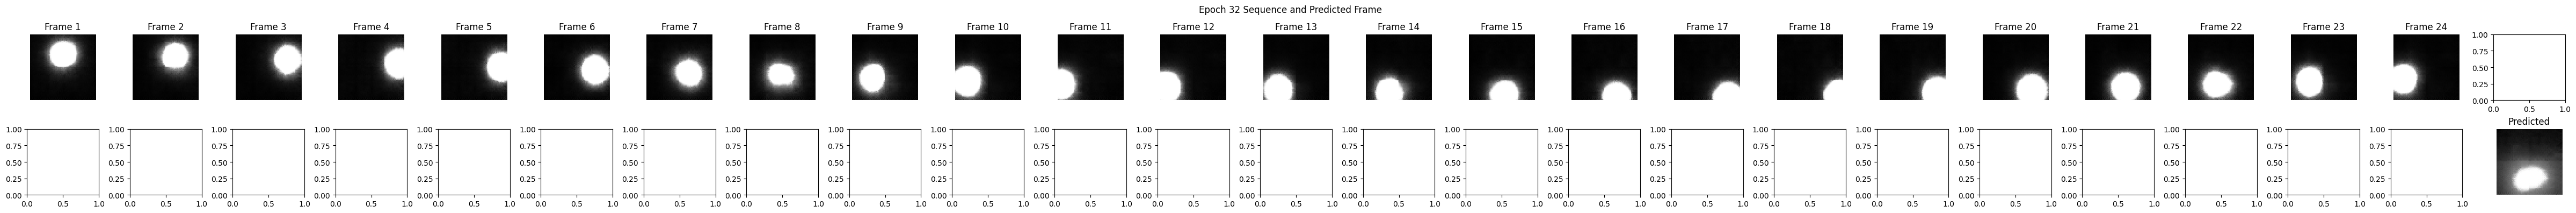

Epoch 33, Loss: 5174.98291015625
Epoch 34, Loss: 6688.58154296875


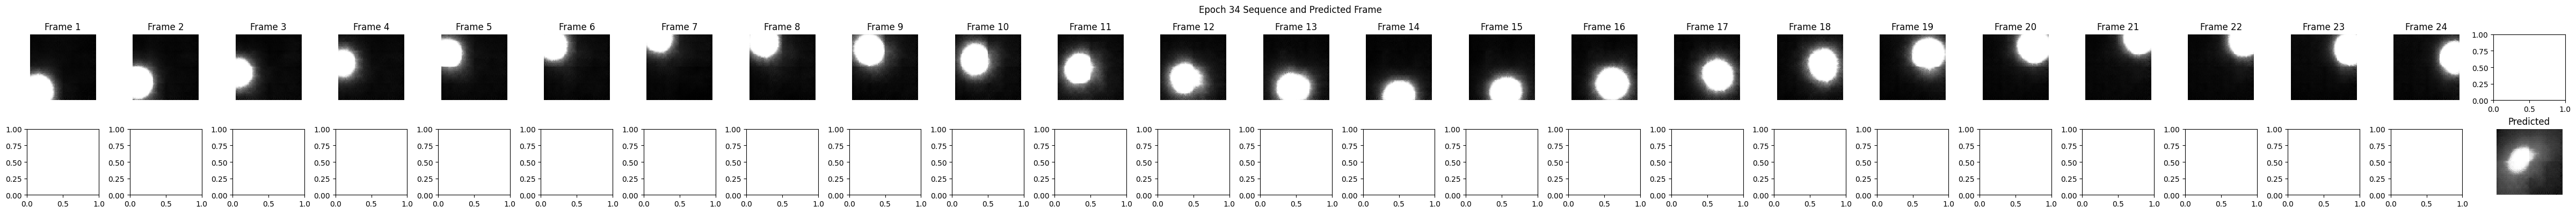

Epoch 35, Loss: 7897.87255859375
Epoch 36, Loss: 8676.8232421875


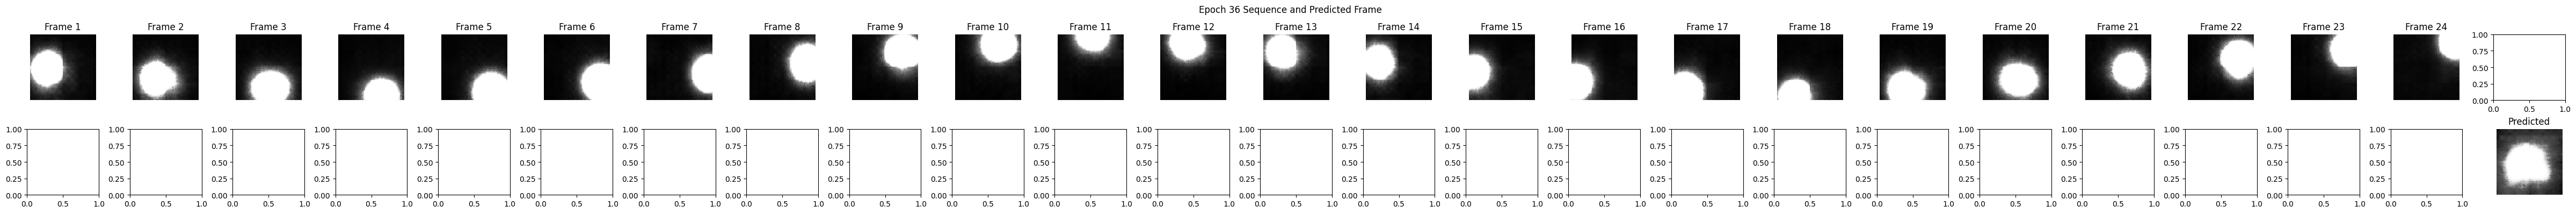

Epoch 37, Loss: 7436.13720703125
Epoch 38, Loss: 9008.66015625


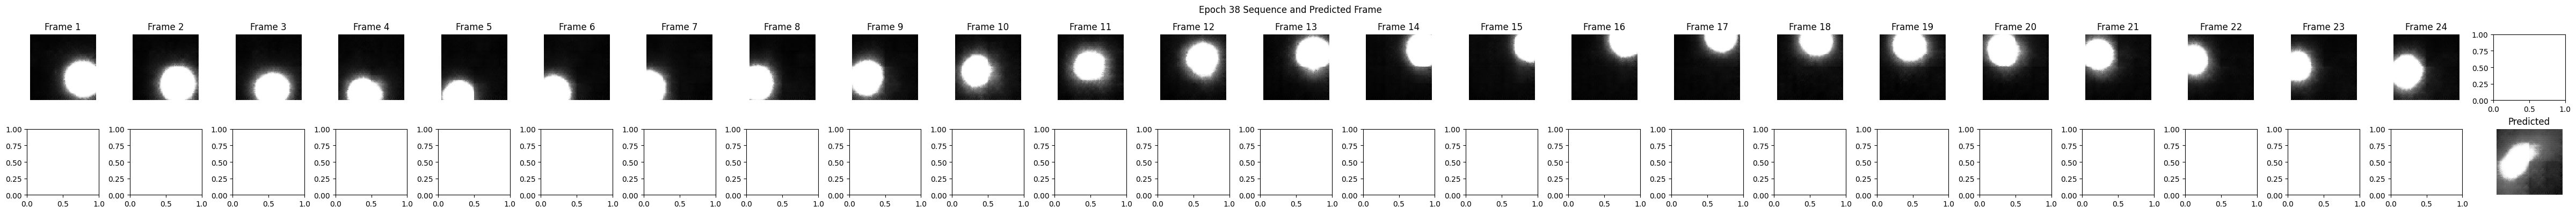

Epoch 39, Loss: 5595.14697265625
Epoch 40, Loss: 8165.6396484375


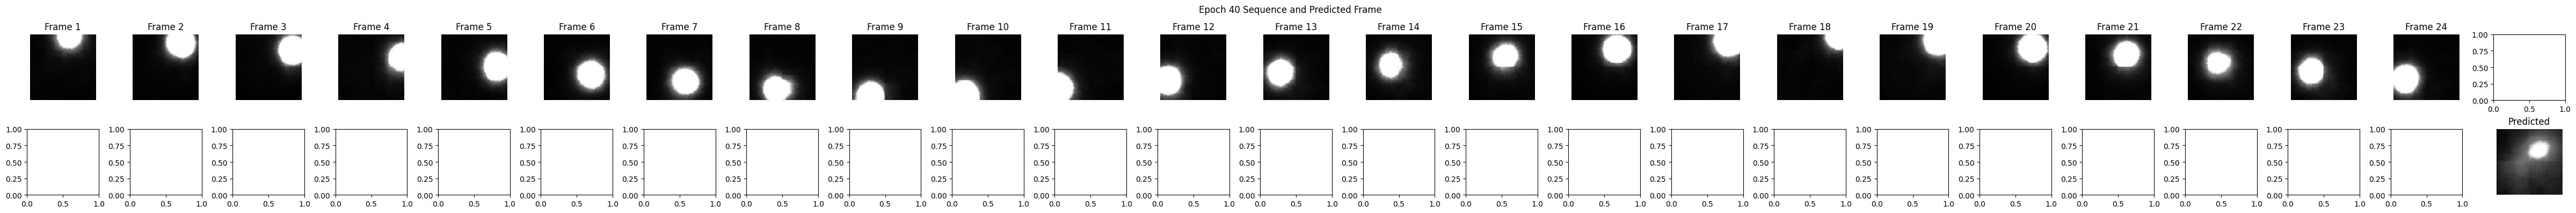

Epoch 41, Loss: 5953.24462890625
Epoch 42, Loss: 6981.2109375


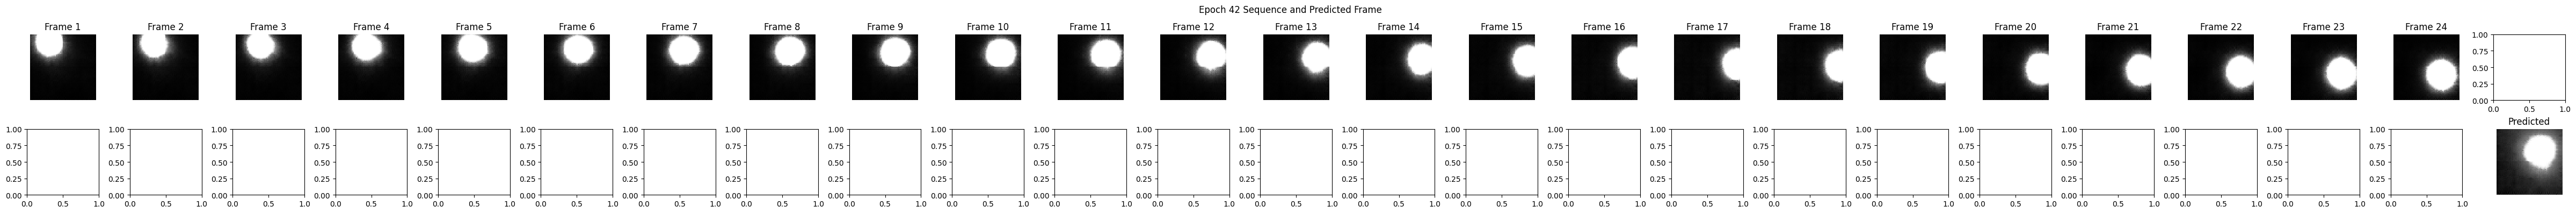

Epoch 43, Loss: 5807.14404296875
Epoch 44, Loss: 7148.24609375


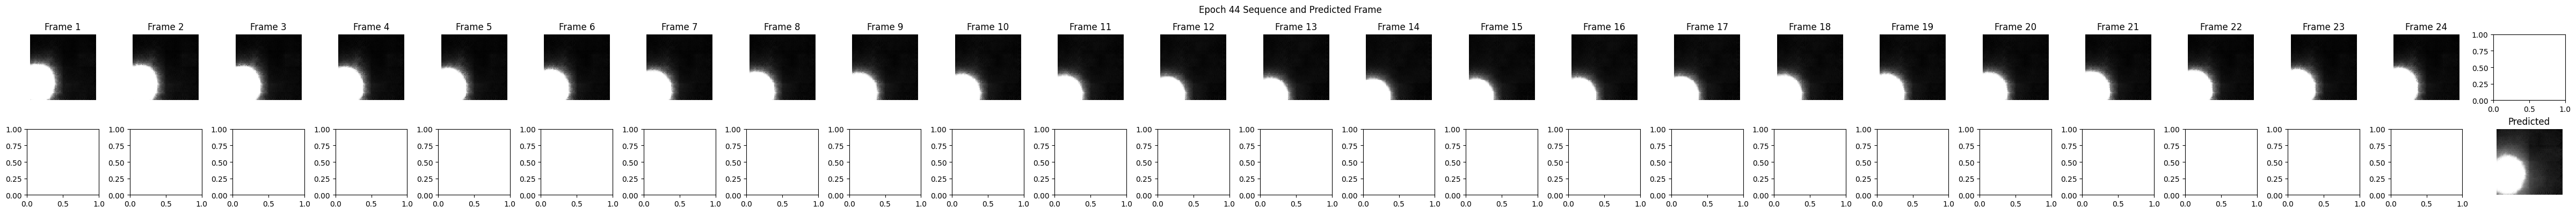

Epoch 45, Loss: 6294.15625
Epoch 46, Loss: 6565.11962890625


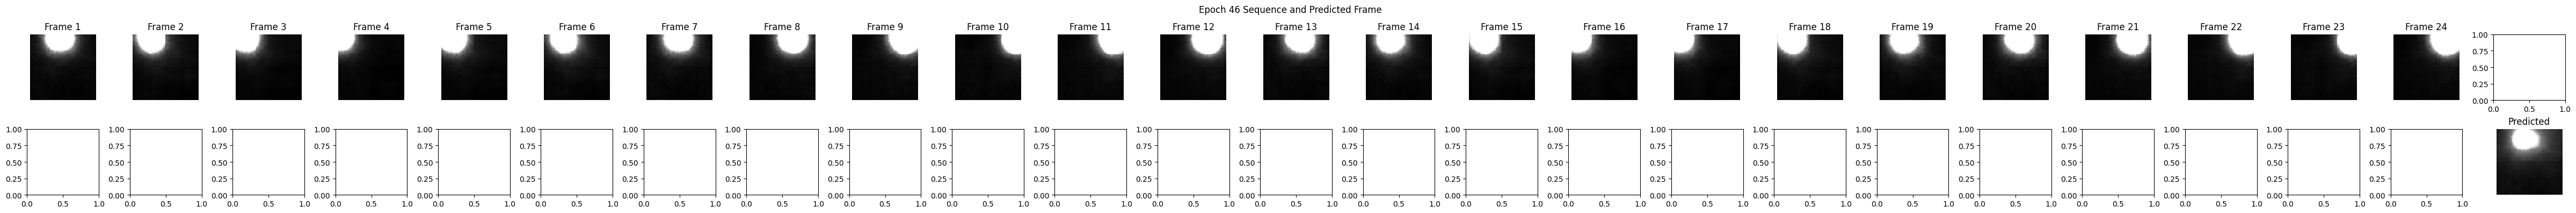

Epoch 47, Loss: 5922.13330078125
Epoch 48, Loss: 7830.49609375


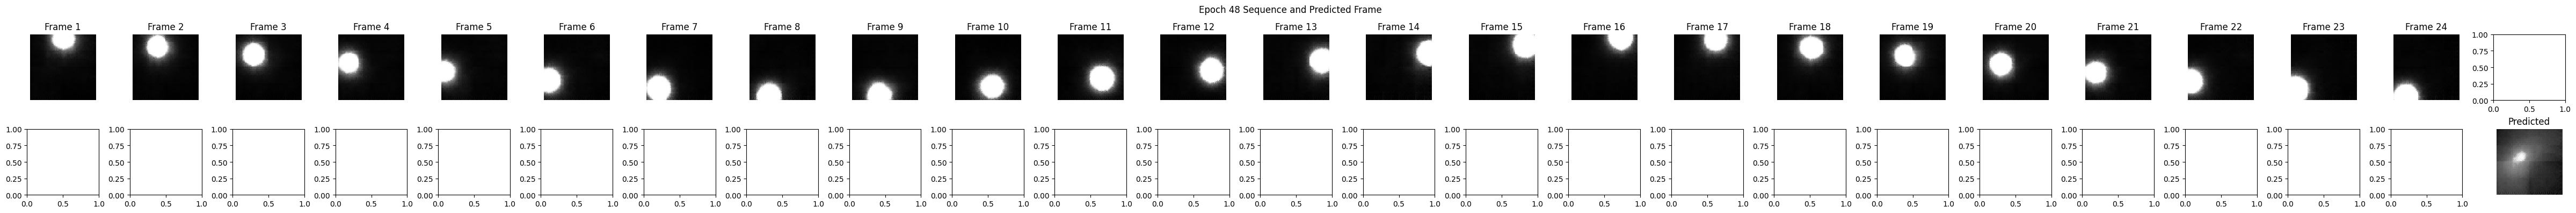

Epoch 49, Loss: 6322.74755859375
Epoch 50, Loss: 4966.95458984375


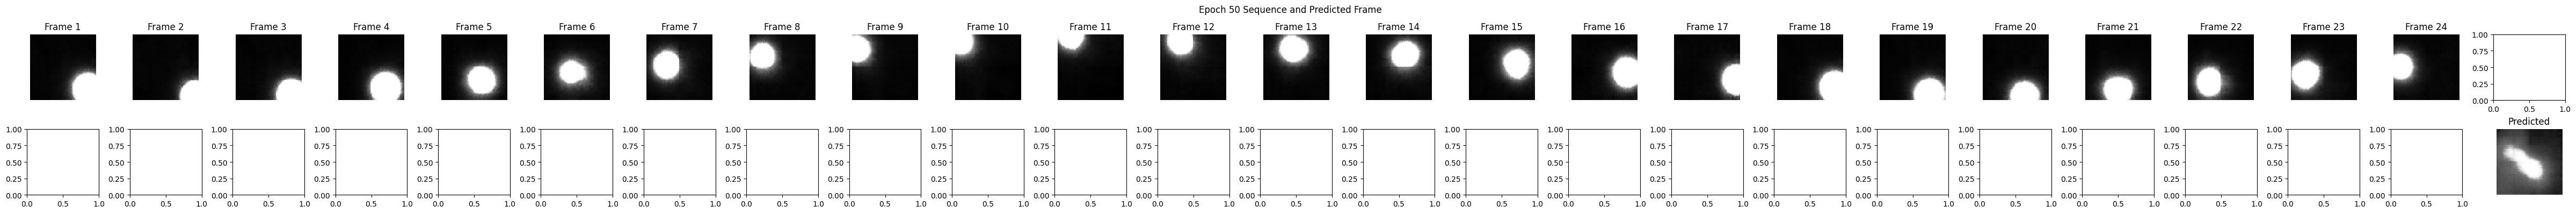

In [201]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
model.train()
for epoch in range(50):  
    for src, tgt in train_loader:
        # print(src.shape, tgt.shape)
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        bottleneck_pred  = model(src, tgt[:, :-1])  
        loss = criterion(bottleneck_pred, tgt[:, 1:])  
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    if (epoch + 1) % 2 == 0 or epoch == 0:  
        with torch.no_grad():
            decoded_src = decoder(src[0,:,:].detach()).cpu()  
            predicted_frame = decoder(bottleneck_pred[:, -1].detach()).cpu()  

            plot_sequence_and_prediction(decoded_src, predicted_frame[:1], title=f"Epoch {epoch+1} Sequence and Predicted Frame")

In [202]:
output_dir1= r'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test'
save_encoded_features(bottleneck_encoder,test_loader,output_dir=output_dir1)

(32, 25, 128)
Saved encoded features for batch 0 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_0.npy'


(32, 25, 128)
Saved encoded features for batch 1 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_1.npy'
(32, 25, 128)
Saved encoded features for batch 2 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_2.npy'
(32, 25, 128)
Saved encoded features for batch 3 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_3.npy'
(32, 25, 128)
Saved encoded features for batch 4 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_4.npy'
(32, 25, 128)
Saved encoded features for batch 5 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_5.npy'
(32, 25, 128)
Saved encoded features for batch 6 at 'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test\features_batch_6.npy'
(32, 25, 128)
Saved encoded features for batch 7 at 

In [209]:
def load_features(directory):
    files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')])
    all_features = [np.load(file) for file in files]
    return np.concatenate(all_features, axis=0)  

features_directory_test = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\hw-2\bottleneck\CNN_autoencoder\test'
encoded_features_test = load_features(features_directory_test)  
print(encoded_features_test.shape)

(400, 25, 128)


In [210]:
def create_sequences(features, sequence_length):
    inputs, targets = [], []
    for n in range(features.shape[0]):  
        for i in range(features.shape[1] - sequence_length):
            input_seq = features[n, i:i + sequence_length, :]
            target_seq = features[n, i + 1:i + 1 + sequence_length, :]
            inputs.append(input_seq)
            targets.append(target_seq)
    
    return np.array(inputs), np.array(targets)

sequence_length = 14  


test_inputs, test_targets = create_sequences(encoded_features_test, sequence_length)
print(test_inputs.shape, test_targets.shape)

(4400, 14, 128) (4400, 14, 128)


In [211]:
from torch.utils.data import DataLoader, TensorDataset
def plot_sequence_and_prediction(input_sequence, predicted_frame, idx, title="Sequence and Predicted Frame"):
    fig, axes = plt.subplots(1, len(input_sequence)+1, figsize=(20, 2))
    for i in range(len(input_sequence)):
        axes[i].imshow(input_sequence[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Input Frame {i+1}')
        axes[i].axis('off')

    # Plot the predicted frame
    axes[-1].imshow(predicted_frame.squeeze(), cmap='gray')
    axes[-1].set_title('Predicted Next Frame')
    axes[-1].axis('off')

    plt.suptitle(f"{title} - Sample {idx}")
    plt.show()

test_inputs_tensor = torch.from_numpy(test_inputs).float()
test_targets_tensor = torch.from_numpy(test_targets).float()


test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

test_loader_seq = DataLoader(test_dataset, batch_size=20, shuffle=False)
def evaluate_model(model, test_loader, device, decoder, num_samples=25):
    model.eval()
    total_loss = 0
    sample_indices = np.random.choice(len(test_loader.dataset), num_samples, replace=False)  # Randomly pick indices to plot
    samples_processed = 0

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader_seq):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data, targets[:, :-1])
            loss = criterion(outputs, targets[:, 1:]) 
            total_loss += loss.item()

            if batch_idx in sample_indices:
                for i in range(data.size(0)):
                    if samples_processed >= num_samples:
                        break
                    decoded_inputs = [decoder(data[i, j, :].detach()).cpu() for j in range(data.size(1))]
                    decoded_inputs = np.array(decoded_inputs)
                    predicted_frame = decoder(outputs[i, -1, :].detach()).cpu()  # Get the last predicted frame
                    plot_sequence_and_prediction(decoded_inputs, predicted_frame, samples_processed + 1)
                    samples_processed += 1

    avg_loss = total_loss / len(test_loader)
    print(f'Average Loss: {avg_loss:.4f}')
    return avg_loss


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
decoder.to(device)  
avg_test_loss = evaluate_model(model, test_loader_seq, device, decoder)



TypeError: VisionTransformerConvDecoder.forward() takes 2 positional arguments but 3 were given

In [206]:
#this is without time2vector

import torch
import torch.nn as nn
import torch.optim as optim

#embed dim= dim of bottle neck
# Define the Vision Transformer as the image encoder
# class VisionTransformer(nn.Module):
#     def __init__(self, input_channels=1, patch_size=4, num_classes=1000, embed_dim=4, num_heads=4, num_layers=4):
#         super(VisionTransformer, self).__init__()
#         self.patch_size = patch_size
#         self.num_patches = (64 // patch_size) ** 2  # Assuming input image size is 64x64
#         self.embedding = nn.Conv2d(input_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
#         self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable token for classification
#         self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))  # Positional encoding
#         self.transformer_encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
#             num_layers=num_layers
#         )
#         self.fc = nn.Linear(embed_dim, num_classes)

#     def forward(self, x):
#         print(x.shape)
#         b, c, h, w = x.shape
#         assert h == w == 64, "Input image size must be 64x64" #torch.Size([8, 1, 64, 64])
#         x = self.embedding(x)  # (batch_size, embed_dim, num_patches) after embedingtorch.Size([8, 128, 8, 8])
#         print(f'after embeding{x.shape}')
#         x = x.flatten(2).permute(2, 0, 1)  # (num_patches, batch_size, embed_dim)
#         print(f'after flattening{x.shape}')
#         cls_tokens = self.cls_token.expand(-1, b, -1)
#         print(f'class token {cls_tokens.shape}')
#         x = torch.cat((cls_tokens, x), dim=0)  # (num_patches + 1, batch_size, embed_dim)
#         print(f'shape after cat between cat and flaten x {x.shape}' )
#         print(f'xshape={x.shape}, position={self.positional_encoding.shape}') #xshape=torch.Size([65, 8, 128]), position=torch.Size([1, 65, 128])
#         x = x + self.positional_encoding  # Add positional encoding
#         print(x.shape)
#         x = self.transformer_encoder(x)  # Transformer encoder
#         x = x.mean(0)  # Mean pooling over patches
#         x = self.fc(x)  # Classification
#         return x


# import torch.nn as nn



class VisionTransformer(nn.Module):
    def __init__(self, input_channels=1, patch_size=4, num_classes=1000, embed_dim=4, num_heads=4, num_layers=4):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (64 // patch_size) ** 2  # Assuming input image size is 64x64
        self.embedding = nn.Conv2d(input_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable token for classification
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))  # Positional encoding
        # self.transformer_encoder = nn.TransformerEncoder(
        #     nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
        #     num_layers=num_layers
        # )
        # self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        b, c, h, w = x.shape
        assert h == w == 64, "Input image size must be 64x64"
        x = self.embedding(x)  # (batch_size, embed_dim, num_patches)
        x = x.flatten(2).permute(2, 0, 1)  # (num_patches, batch_size, embed_dim)
        cls_tokens = self.cls_token.expand(self.num_patches, -1, -1)  # Expand cls_token to match the number of patches
        x = torch.cat((cls_tokens, x), dim=1)  # (num_patches + 1, batch_size, embed_dim)
        x = x + self.positional_encoding  # Add positional encoding
        x = self.transformer_encoder(x)  # Transformer encoder
        x = x.mean(0)  # Mean pooling over patches
        x = self.fc(x)  # Classification
        return x








# Define the Convolutional Decoder
class ConvolutionalDecoder(nn.Module):
    def __init__(self):
        super(ConvolutionalDecoder, self).__init__()
        # Define the decoder layers (e.g., transposed convolutional layers)
        # self.decoder_layers = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
        #     nn.Sigmoid()
        # )
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (5,1)), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder_layers(x)
        return x

# Define the vision transformer/convolutional decoder pair
class VisionTransformerConvDecoder(nn.Module):
    def __init__(self):
        super(VisionTransformerConvDecoder, self).__init__()
        # Instantiate the VisionTransformer and ConvolutionalDecoder
        self.vision_transformer = VisionTransformer()
        self.conv_decoder = ConvolutionalDecoder()

    def forward(self, x):
        # Pass input through the VisionTransformer (image encoder)
        x = self.vision_transformer(x)
        # Pass the latent representation through the ConvolutionalDecoder
        x = self.conv_decoder(x)
        return x

# Instantiate the model
model = VisionTransformerConvDecoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


ValueError: not enough values to unpack (expected 4, got 3)

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Flatten
from tensorflow.keras.layers import LayerNormalization


class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear', shape=(int(self.seq_len),), initializer='uniform', trainable=True)
    self.bias_linear = self.add_weight(name='bias_linear', shape=(int(self.seq_len),), initializer='uniform', trainable=True)
    self.weights_periodic = self.add_weight(name='weight_periodic', shape=(int(self.seq_len),), initializer='uniform', trainable=True)
    self.bias_periodic = self.add_weight(name='bias_periodic', shape=(int(self.seq_len),), initializer='uniform', trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1)
    return tf.concat([time_linear, time_periodic], axis=-1)


class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out
#check from this 
class MultiAttention(Layer):
    def __init__(self, nr_heads, d_k, d_v, embedding_dim):
        super(MultiAttention, self).__init__()
        self.nr_heads = nr_heads
        self.d_k = d_k
        self.d_v = d_v
        self.embedding_dim = embedding_dim
        self.attention_heads = []

    def build(self, input_shape):
        for i in range(self.nr_heads):
            self.attention_heads.append(SingleAttention(self.d_k, self.d_v))
        self.linear = tf.keras.layers.Dense(self.embedding_dim)

    def call(self, x):
        attention = []
        for i in range(self.nr_heads):
            attention.append(self.attention_heads[i]([x, x, x]))
        concat_attention = tf.concat(attention, axis=-1)
        x = self.linear(concat_attention)
        return x
    
class Transformer(Layer):
    def __init__(self, dk, dv, embedding_len, dropout_rate, seq_len, n_heads):
        super(Transformer, self).__init__()
        self.dk = dk
        self.dv = dv
        self.dropout_rate = dropout_rate
        self.seq_len = seq_len
        self.n_heads = n_heads
        self.embedding_len = embedding_len

    def build(self, input_shape):
        self.t2v = Time2Vector(self.seq_len)
        self.multi_attention = MultiAttention(self.n_heads, self.dk, self.dv, self.embedding_len)
        self.dropout = Dropout(self.dropout_rate)
        self.normalize = LayerNormalization(epsilon=1e-3)
        self.dense1 = Dense(16, activation='relu')
        self.dense2 = Dense(8, activation='relu')
        self.dense3 = Dense(self.embedding_len, activation='relu')
        self.dense4 = Dense(input_shape[-1])
        self.flatten = Flatten()
    # def call(self, inputs):
    #     t2v = self.t2v(inputs)
    #     print("Shapes - inputs:", inputs.shape, "t2v:", t2v.shape)
    #     add = tf.concat([inputs, t2v], axis=-1)
    #     print("Shape - add after concatenation:", add.shape)
    #     x = tf.concat([inputs, t2v], axis=-1)
    #     print("Shape - x after concatenation:", x.shape)
    #     x = self.multi_attention(x)
    #     x = self.dropout(x)

    #     x = x + add

    #     x = self.normalize(x)
    #     x = self.dense1(x)
    #     x = self.dropout(x)
    #     x = self.dense2(x)
    #     x = self.dense3(x)

    #     x = x + add
    #     x = self.normalize(x)
    #     x = self.flatten(x)
    #     x = self.dense4(x)
    #     return x

    def call(self, inputs):
        t2v = self.t2v(inputs)
        add = tf.concat([inputs, t2v], axis=-1)
        x = tf.concat([inputs, t2v], axis=-1)
        x = self.multi_attention(x)
        x = self.dropout(x)

        x = x + add  # Residual connection added here

        x = self.normalize(x)  # Normalization applied after the residual connection
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dense3(x)

        x = x + add  # Another residual connection added here
        x = self.normalize(x)  # Normalization applied after the residual connection
        x = self.flatten(x)
        x = self.dense4(x)
        return x


In [43]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        
        # N , 4
        self.decoder = nn.Sequential(
            nn.Linear(4, 128*4*4), # -> N, 128*4*4
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)), # -> N, 128, 4, 4
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # N, 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 32, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 32, 32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 64, 64
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.transformer(x)
        decoded = self.decoder(encoded)
        return decoded

transformer = Transformer(dk=10, dv=10, embedding_len=4, dropout_rate=0.1, seq_len=1, n_heads=5)
autoencoder = Autoencoder(transformer)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

num_epochs = 5
outputs = []

for epoch in range(num_epochs):
    for (img, _) in train_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = autoencoder(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

InvalidArgumentError: Exception encountered when calling Transformer.call().

[1m{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [8,1,64,4] vs. [8,1,64,66] [Op:AddV2] name: [0m

Arguments received by Transformer.call():
  • inputs=tf.Tensor(shape=(8, 1, 64, 64), dtype=float32)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class VisionTransformer(nn.Module):
    def __init__(self, num_classes=1000, seq_len=64):
        super(VisionTransformer, self).__init__()
        self.seq_len = seq_len
        
        # Time2Vector layer for encoding positional information
        self.time2vector = Time2Vector(seq_len)
        
        # ResNet50 as the backbone
        self.backbone = resnet50(pretrained=False)  # You can set pretrained=True if you want to use a pretrained backbone
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the classification head
        
        # Define linear projection layers for class token and positional encoding
        self.class_token = nn.Parameter(torch.randn(1, 1, num_features))
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, num_features))
        
        # Define attention and projection layers
        self.attention = SingleAttention(num_features, num_features)
        self.projection = nn.Linear(num_features, num_features)
        
    def forward(self, x):
        # Encode positional information
        t = self.time2vector(x)
        x = x + t
        
        # Apply backbone network
        x = self.backbone(x)
        
        # Add class token and positional encoding
        cls_tokens = self.class_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.positional_encoding
        
        # Apply attention mechanism
        x = self.attention(x)
        
        # Apply linear projection
        x = self.projection(x)
        
        return x
class ConvolutionalDecoder(nn.Module):
    def __init__(self):
        super(ConvolutionalDecoder, self).__init__()

        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (5,1)), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder_layers(x)
        return x

# Define the vision transformer/convolutional decoder pair
class VisionTransformerConvDecoder(nn.Module):
    def __init__(self):
        super(VisionTransformerConvDecoder, self).__init__()
        # Instantiate the VisionTransformer and ConvolutionalDecoder
        self.vision_transformer = VisionTransformer()
        self.conv_decoder = ConvolutionalDecoder()

    def forward(self, x):
        # Pass input through the VisionTransformer (image encoder)
        x = self.vision_transformer(x)
        # Pass the latent representation through the ConvolutionalDecoder
        x = self.conv_decoder(x)
        return x

# Instantiate the model
model = VisionTransformerConvDecoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()



c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\purus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [8,1,64,64] vs. [8,1,64,2] [Op:AddV2] name: 